# sprint0: Global

In [682]:
import numpy as np
np.random.seed(42)

In [683]:
# libraries
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from multiprocessing import Pool

In [684]:
# CONST
RANDOM_STATE = 42

In [685]:
# utils
def fixRandomState(fixed_state):
  np.random.seed(fixed_state)

def exception(condition: bool, notification):
  if(condition == False):
    print("__exception__: ", notification)
    assert(1 == 0)

def verbose(flag: bool, verbose):
  if(flag):
    print("__verbose__: ", verbose)

def note(note):
  print("__note__: ", note)

def hashNP(val: np) -> float:
  return round(np.sqrt(np.sum(val**2)), 10), round(np.sum(val), 10)


# sprint1: Layer class

In [686]:
# static attributies and methos
AMPHA, INIT_LOC, INIT_STD = 1e-2, 1e2, 1e2
def configAllLayers(ampha, init_loc, init_std):
  AMPHA, INIT_LOC, INIT_STD = ampha, init_loc, init_std

## Interface

In [687]:
class LayerInterface:
  def __init__(self) -> None:
    self.parameters = np.array([])
    self.input = np.array([])
    self.loss_output = np.array([])

  def set_parameters(self, val: np) -> None:
    self.parameters = val.copy()
  def set_input(self, val: np) -> None:
    self.input = val.copy()
  def set_loss_output(self, val: np) -> None:
    self.loss_output = val.copy()

  def getParameters(self) -> tuple:
    return self.parameters.shape, hashNP(self.parameters)
  def getInput(self) -> tuple:
    return self.input.shape, hashNP(self.input)
  def getLossOutput(self) -> tuple:
    return self.loss_output.shape, hashNP(self.loss_output)

  def transform(self, *argv):
    pass
  def cap(self, *argv):
    pass
  def back(self, *argv):
    pass
  def update(self, *argv):
    pass

  def init_method(self, size_parameters: tuple, fixed_state: int = -1) -> np:
    if(fixed_state != -1):
      fixRandomState(fixed_state)
    return np.random.normal(loc = INIT_LOC, scale = INIT_STD, size = size_parameters)

  def update_method(self, parameters: np, gradient: np) -> np:
    return parameters - AMPHA * gradient

## Padding

In [688]:
class Padding(LayerInterface):
  def __init__(self, a: int, b: int, c: int, d: int) -> None:
    super().__init__()
    self.a, self.b, self.c, self.d = a, b, c, d

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    z = tf.convert_to_tensor(z, np.float64)
    padding = tf.constant([[self.a, self.b], [self.c, self.d]])
    z = tf.pad(z, padding, mode ='CONSTANT')
    z = z.numpy()
    return z

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    return out[self.a : out.shape[0] - self.b, self.c : out.shape[1] - self.d]


## Convolution

In [689]:
class Convolution(LayerInterface):
  def __init__(self, fixed_state = RANDOM_STATE, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.fixed_state = fixed_state
    self.size = size
    self.filter = self.init_method(self.size, self.fixed_state)

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = self.conv_operator(one_point, self.filter)
    return z

  def cap(self, one_point: np) -> None:
    self.one_point = one_point.copy()

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    dF = self.conv_operator(self.one_point, one_output)
    out = Padding(self.size[0]-1, self.size[0]-1, self.size[1]-1, self.size[1]-1).transform(one_output)
    dX = self.conv_operator(out, self.rotate_180(self.filter))
    return dX, dF

  def update(self, gradient: np) -> None:
    self.filter = self.update_method(self.filter, gradient)
    self.set_parameters(self.filter)

  def conv_operator(self, X: np, F: np) -> np:
    a, b = F.shape
    u, v = X.shape[0] - a + 1, X.shape[1] - b + 1
    z = np.zeros((u, v))
    for i in range(u):
      for j in range(v):
        z[i, j] = np.sum(X[i : i + a, j : j + b] * F)
    return z

  def rotate_180(self, A: np) -> np:
    return np.array([row[::-1] for row in A[::-1]])


In [690]:
class MultiConvolution(LayerInterface):
  def __init__(self) -> None:
    pass

## Pooling

In [691]:
class Pooling(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np, mode: str) -> np:
    exception(one_point.shape[0] % self.size[0] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))
    exception(one_point.shape[1] % self.size[1] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))

    self.set_input(one_point)
    z = np.zeros((one_point.shape[0] // self.size[0], one_point.shape[1] // self.size[1]))
    for i in range(0, one_point.shape[0], self.size[0]):
      for j in range(0, one_point.shape[1], self.size[1]):
        if(mode == 'mean'):
          z[i // self.size[0], j // self.size[1]] = np.mean(one_point[i : i + self.size[0], j : j + self.size[1]])
        elif(mode == 'max'):
          z[i // self.size[0], j // self.size[1]] = np.max(one_point[i : i + self.size[0], j : j + self.size[1]])
    return z

  def zoom(self, one_output: np) -> np:
    zoom = np.zeros((one_output.shape[0] * self.size[0], one_output.shape[1] * self.size[1]))
    for i in range(zoom.shape[0]):
      for j in range(zoom.shape[1]):
        zoom[i, j] = one_output[i // self.size[0], j // self.size[1]]
    return zoom


In [692]:
class AveragePooling(Pooling):
  def __init__(self, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.size = size

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return super().transform(one_point, 'mean')

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return self.zoom(one_output) / (self.size[0] * self.size[1])


In [693]:
class MaxPooling(Pooling):
  def __init__(self, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.size = size

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return super().transform(one_point, 'max')

  def cap(self, one_point: np) -> np:
    exception(one_point.shape[0] % self.size[0] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))
    exception(one_point.shape[1] % self.size[1] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))

    self.mask = np.zeros((one_point.shape[0], one_point.shape[1]))
    for i in range(0, one_point.shape[0], self.size[0]):
      for j in range(0, one_point.shape[1], self.size[1]):
        li, lj = i, j
        for k in range(i, i + self.size[0]):
          for t in range(j, j + self.size[1]):
            if(one_point[k][t] > one_point[li][lj]):
              li, lj = k, t
        self.mask[li][lj] = 1

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return self.zoom(one_output) * self.mask


## Flatten

In [694]:
class Flatten(LayerInterface):
  def __init__(self):
    super().__init__()
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    length = 1
    for i in range(len(z.shape)):
      length *= z.shape[i]
    return z.reshape(length, 1)

  def cap(self, one_point: np) -> None:
    self.shape_one_point = one_point.shape

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    out = np.reshape(out, self.shape_one_point)
    return out


## Fully Connected

In [695]:
class Dense(LayerInterface):
  def __init__(self, fixed_state = RANDOM_STATE, size_output: int = 1) -> None:
    super().__init__()
    self.fixed_state = fixed_state
    self.size_output = size_output
    self.W = self.init_method((self.size_output, 1), self.fixed_state)

  def check_init_shape(self, one_point: np) -> None:
    if(self.W.shape != (self.size_output, one_point.shape[0] + 1)):
      self.W = self.init_method((self.size_output, one_point.shape[0] + 1), self.fixed_state)

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    self.check_init_shape(one_point)
    z = one_point.copy()
    z =  np.append(z, np.array([[1]]), axis = 0) #$ append 1 at last
    return np.matmul(self.W, z)

  def cap(self, one_point: np) -> None:
    self.check_init_shape(one_point)
    z = one_point.copy()
    self.append_one_point = np.append(z, np.array([[1]]), axis = 0)  #$ append 1 at last

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    dW = np.matmul(out, self.append_one_point.T)
    dX = np.matmul(self.W.T, out)
    return dX[:-1], dW

  def update(self, gradient: np) -> np:
    self.W = self.update_method(self.W, gradient)
    self.set_parameters(self.W)

## Activation

In [696]:
class Activation(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

In [697]:
class ReLU(Activation):
  def __init__(self) -> None:
    super().__init__()
    self.rate = 0
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return self.relu(one_point)

  def cap(self, one_point: np) -> None:
    self.mask = np.where(one_point >= 0, 1, self.rate)

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return one_output.copy() * self.mask

  def relu(self, one_point: np) -> np:
    x = one_point.copy()
    return np.where(x >= 0, x, self.rate * x)


In [698]:
class Sigmoid(Activation):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return self.sigmoid(one_point)

  def cap(self, one_point: np) -> None:
    self.one_point = one_point.copy()

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    sig = self.sigmoid(self.one_point)
    return one_output.copy() * sig * (1 - sig)

  def sigmoid(self, x: np) -> np:
    return 1 / (1 + np.exp(-x))


## Loss

In [699]:
class Loss(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

In [700]:
class StableBinaryCrossEntropy(Loss):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np, one_y: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    y = one_y.copy()
    # return -y * np.log(a) -(1-y) * np.log(1-a)
    # print("loss: ", -(-y * np.log(1 + np.exp(-z)) + (1 - y) * (-z - np.log(1 + np.exp(-z)))))
    return -(-y * np.log(1 + np.exp(-z)) + (1 - y) * (-z - np.log(1 + np.exp(-z))))

  def cap(self, one_point: np, one_y: np) -> None:
    self.one_point = one_point.copy()
    self.one_y = one_y.copy()

  def back(self) -> np:
    z = self.one_point
    y = self.one_y
    a = 1 / (1 + np.exp(-z))
    return a - y


# sprint2: Network class

In [701]:
class Network:
  def __init__(self) -> None:
    self.network = []

  def add(self, layers) -> None:
    if(isinstance(layers, list)):
      self.network.extend(layers)
    else:
      self.network.append(layers)

  def addLoss(self, loss_layer: Loss) -> None:
    exception(isinstance(loss_layer, Loss), "Network > addLoss: not is a Loss layer")

    self.network.append(loss_layer)

###################################################################################################
  def forward_operator(self, one_point: np, df) -> np:
    z = one_point.copy()
    for i, layer in enumerate(self.network[:-1]): #$ not have loss
      layer.cap(z)
      z = layer.transform(z).copy()
      # catch
      df['layer {}'.format(i)].append(layer.getInput())
      df['layer {}'.format(i)].append(layer.getParameters())
    return z

  def backprop_operator(self, one_output: np, df) -> np:
    out = one_output.copy()
    for i in range(len(self.network)-2, -1, -1):
      layer = self.network[i]
      der = layer.back(out)
      if(isinstance(der, tuple)):
        out = der[0]
        layer.update(der[1])
      else:
        out = der
      # catch
      df['layer {}'.format(i)].append(layer.getLossOutput())
      df['layer {}'.format(i)].append(layer.getParameters())
    return out

###################################################################################################
  def fit_one_point(self, one_point: np, one_y: np, noisy = False) -> np:
    df = defaultdict(list) # catch
    z = self.forward_operator(one_point, df) # forward
    self.network[-1].cap(z, one_y)
    loss_value = round(np.sum(self.network[-1].transform(z, one_y)), 6) # loss
    out = self.network[-1].back() # backprop
    self.backprop_operator(out, df)

    df['row meaning'].extend(["Hash(input)", "before Hash(params)", "Hash(dL/douput)", "after Hash(params)"])
    self.df = pd.DataFrame(df)
    if(noisy):
      verbose(noisy, "Network > fit_one_point: ")
      print(self.df)
      print("z_lass: ", z)
      print("loss_value: ", loss_value)
      print("dL/dz: ", out)
    return loss_value

  def fit(self, set_points: np, set_y: np, num_epoch: int = 100, noisy = False) -> None:
    exception(set_points.shape[0] == set_y.shape[0], "Network > fit_set_points: size of sample {} {}".format(set_points.shape, set_y.shape))

    self.mean_loss = []
    for _ in range(num_epoch):
      mean_loss = []
      for i, one_point in enumerate(set_points):
        one_y = set_y[i]
        loss_value = self.fit_one_point(one_point, one_y, noisy = False)
        mean_loss.append(loss_value)
        # return #!!!
      mean_loss = np.mean(mean_loss)
      if(noisy):
        verbose(noisy, "Network > fit > (epoch) = ({}): mean_loss_iteration_in_epoch = {}".format(_, mean_loss))
      self.mean_loss.append(mean_loss)
    # return self.mean_loss

###################################################################################################
  def getOutputLayer(self, one_point: np, index: int, noisy = False) -> np:
    z = one_point.copy()
    for i, layer in enumerate(self.network[:index+1]):
      z = layer.transform(z).copy()
      if(noisy):
        verbose(noisy, "Network > getOutputLayer > (layer) = ({}): ".format(i))
        print("Hash(input): ", layer.getInput())
        print("Hash(params): ", layer.getParameters())
        print("Hash(output): ", hashNP(z))
    return z

  def predict(self, set_points: np) -> np:
    predictions = np.array([])
    for i, one_point in enumerate(set_points):
      predictions = np.append(predictions, self.getOutputLayer(one_point, len(self.network)-2))
    return predictions


#sprint3: Architech

In [702]:
configAllLayers(1e-2, np.random.randint(10), np.random.randint(10))

In [703]:
net = Network()
net.add([Convolution(size = (7, 7)), ReLU()])
net.add([Convolution(size = (3, 3)), ReLU()])

net.add([MaxPooling(size = (2, 2))])

net.add(Flatten())

net.add([Dense(size_output = 16), ReLU()])
net.add([Dense(size_output = 8), ReLU()])

net.add(Dense(size_output = 1))
net.addLoss(StableBinaryCrossEntropy())

# sprint3: Data

In [704]:
from keras.datasets import mnist

- load data

In [705]:
# load data
(x_in, y_in), (x_out, y_out) = mnist.load_data()

In [706]:
# print(x_in)
print(y_in)
# print(x_out)
print(y_out)

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


- select data

In [707]:
indexing = np.where((y_in == 0) | (y_in == 1))
y_in = y_in[indexing]
x_in = x_in[indexing]
y_in

array([0, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [708]:
indexing = np.where((y_out == 0) | (y_out == 1))
y_out = y_out[indexing]
x_out = x_out[indexing]
y_out

array([1, 0, 1, ..., 1, 0, 1], dtype=uint8)

In [709]:
y_in = y_in[:100]
x_in = x_in[:100]
y_out = y_out[:100]
x_out = x_out[:100]

- cast type and shape

In [710]:
print(type(x_in), x_in.shape)
print(type(x_out), x_out.shape)
print(type(y_in), y_in.shape)
print(type(y_out), y_out.shape)

<class 'numpy.ndarray'> (100, 28, 28)
<class 'numpy.ndarray'> (100, 28, 28)
<class 'numpy.ndarray'> (100,)
<class 'numpy.ndarray'> (100,)


- observe data

In [711]:
print("#image 1: ", np.sum(y_in == 1))
print("#image 0: ", np.sum(y_in == 0))
print("#image: ", y_in.shape)

#image 1:  57
#image 0:  43
#image:  (100,)


## Fit

In [712]:
net.fit(x_in, y_in, num_epoch = 100, noisy = True)

__verbose__:  Network > fit > (epoch) = (0): mean_loss_iteration_in_epoch = 7.636449941022163e+16
__verbose__:  Network > fit > (epoch) = (1): mean_loss_iteration_in_epoch = 22.53740123
__verbose__:  Network > fit > (epoch) = (2): mean_loss_iteration_in_epoch = 22.35250123
__verbose__:  Network > fit > (epoch) = (3): mean_loss_iteration_in_epoch = 22.16760123
__verbose__:  Network > fit > (epoch) = (4): mean_loss_iteration_in_epoch = 21.982701229999996
__verbose__:  Network > fit > (epoch) = (5): mean_loss_iteration_in_epoch = 21.797801229999994
__verbose__:  Network > fit > (epoch) = (6): mean_loss_iteration_in_epoch = 21.61290123
__verbose__:  Network > fit > (epoch) = (7): mean_loss_iteration_in_epoch = 21.428001230000003
__verbose__:  Network > fit > (epoch) = (8): mean_loss_iteration_in_epoch = 21.243101229999997
__verbose__:  Network > fit > (epoch) = (9): mean_loss_iteration_in_epoch = 21.058201230000005
__verbose__:  Network > fit > (epoch) = (10): mean_loss_iteration_in_epoch 

In [713]:
z = net.predict(x_in)
print(z)
preds = 1 / (1 + np.exp(-z))
print(preds)
preds = np.where(preds >= 0.5, 1, 0)
print("accuray after train: ", round(np.sum(preds == y_in) / y_in.shape[0], 6))

[10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217 10.05266217
 10.05266217 10.05266217 10.05266217 10.05266217 10

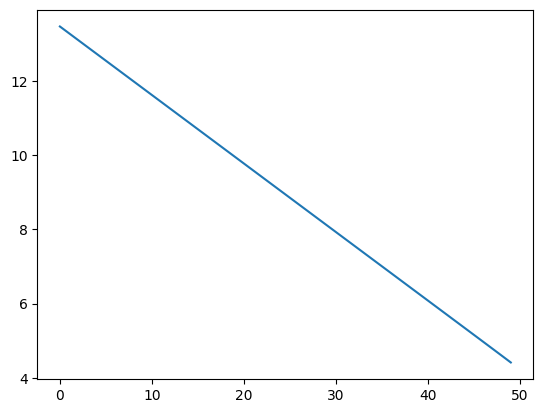

In [714]:
plt.plot(net.mean_loss[50:])

In [715]:
net.getOutputLayer(x_in[0], len(net.network)-2, noisy = True)

__verbose__:  Network > getOutputLayer > (layer) = (0): 
Hash(input):  ((28, 28), (106.7567328088, 31095))
Hash(params):  ((7, 7), (138779615583360.66, -963776503826635.8))
Hash(output):  (1.6261439620575485e+18, -2.9028860338972463e+19)
__verbose__:  Network > getOutputLayer > (layer) = (1): 
Hash(input):  ((22, 22), (1.6261439620575485e+18, -2.9028860338972463e+19))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (2): 
Hash(input):  ((22, 22), (0.0, 0.0))
Hash(params):  ((3, 3), (177053723391125.0, -530965624464091.6))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (3): 
Hash(input):  ((20, 20), (0.0, 0.0))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (4): 
Hash(input):  ((20, 20), (0.0, 0.0))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (5): 
Hash(input):  ((10,

array([[10.05266217]])

In [716]:
net.getOutputLayer(x_in[1], len(net.network)-2, noisy = True)

__verbose__:  Network > getOutputLayer > (layer) = (0): 
Hash(input):  ((28, 28), (73.4098086089, 17135))
Hash(params):  ((7, 7), (138779615583360.66, -963776503826635.8))
Hash(output):  (1.168779341256121e+18, -1.5868253335994941e+19)
__verbose__:  Network > getOutputLayer > (layer) = (1): 
Hash(input):  ((22, 22), (1.168779341256121e+18, -1.5868253335994941e+19))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (2): 
Hash(input):  ((22, 22), (0.0, 0.0))
Hash(params):  ((3, 3), (177053723391125.0, -530965624464091.6))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (3): 
Hash(input):  ((20, 20), (0.0, 0.0))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (4): 
Hash(input):  ((20, 20), (0.0, 0.0))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (5): 
Hash(input):  ((10, 10

array([[10.05266217]])

## Keras

Epoch 1/100
100/100 [==============================] - 2s 5ms/step - loss: 1.2239 - accuracy: 0.5800
Epoch 2/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6880 - accuracy: 0.5700
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6866 - accuracy: 0.5700
Epoch 4/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6857 - accuracy: 0.5700
Epoch 5/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6852 - accuracy: 0.5700
Epoch 6/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.5700
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5700
Epoch 8/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5700
Epoch 9/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5700
Epoch 10/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6852 - accura

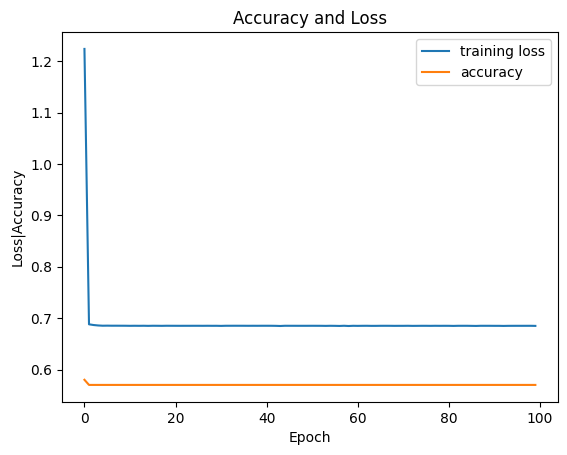

In [717]:
import keras
model = keras.Sequential()

model.add(keras.layers.Conv2D(1, (7, 7), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(1, (3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(
  loss=keras.losses.BinaryCrossentropy(),
  optimizer=keras.optimizers.SGD(learning_rate = 1e-2),
  metrics=['accuracy'])


numOfEpoch = 100
H = model.fit(x_in, y_in,batch_size=1, epochs=numOfEpoch, verbose=1)


fig = plt.figure()

plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
# plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
# plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')

plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()


# end